In [ ]:
import numpy as np
from skimage import io, util, measure, transform
from scipy.ndimage import gaussian_filter
from scipy import interpolate
import pandas as pd
from imageUtils import normalize_image_intensity_signed

from os import path
import stackview
import matplotlib.pyplot as plt
# from scipy.interpolate import NearestNDInterpolator

from measurements import get_bm_image, get_mesh_from_bm_image,get_tissue_curvature_sparse, export_mesh
from trimesh import Trimesh
import pyvista as pv
pv.set_jupyter_backend('trame')

%load_ext autoreload
%autoreload 2


In [ ]:
dirnames = {'M1_R2_t0':'/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/F1 cage 3015 MemGFP NoFUCCI/R2/0. Day 0',
            'M1_R2_t1':'/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/F1 cage 3015 MemGFP NoFUCCI/R2/1. Day 18',
            'M1_R3_t0':'/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/F1 cage 3015 MemGFP NoFUCCI/R3/0. Day 0',
            'M1_R3_t1':'/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/F1 cage 3015 MemGFP NoFUCCI/R3/1. Day 18',
            'M2_R1_t0':'/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/Mgray cage 2157 MemGFP FUCCI/R1/0. Day 0',
            'M2_R1_t1':'/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/Mgray cage 2157 MemGFP FUCCI/R1/1. Day 21',
            'M2_R2_t0':'/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/Mgray cage 2157 MemGFP FUCCI/R2/0. Day 0',
            'M2_R2_t1':'/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/Mgray cage 2157 MemGFP FUCCI/R2/1. Day 21',
           }

In [ ]:
recalculate = False

heightmaps = {}
height_images = {}
# Load heightmaps if exists if not calculate
for name,dirname in dirnames.items():
    file = path.join(dirname,'height_image.tif')
    
    if path.exists(file) and not recalculate:
        height_images[name] = io.imread(file)
        heightmaps[name] = io.imread(path.join(dirname,'heightmap.tif'))
    else:
        B = io.imread(path.join(dirname,'B.tif'))
        heightmap,height_image = get_bm_image(B,
                                              sigmas=[10,20,20], gradient_sign=+1,
                                              method='threshold', threshold=0.2)
        io.imsave(path.join(dirname,'height_image.tif'), height_image)
        io.imsave(path.join(dirname,'heightmap.tif'), heightmap)
        height_images[name] = height_image
        heightmaps[name] = heightmap
        

In [5]:
from measurements import get_tissue_curvature_over_grid

dx = 0.2919921875
dz = 0.7

mean_curve = {}
gaussian_curve = {}
for name,dirname in dirnames.items():

    mesh = get_mesh_from_bm_image(height_images[name],
                                  spacing=[dz,dx,dx],decimation_factor=60)
    export_mesh(mesh,path.join(dirname,'mesh.npz'))
    
    mean_curve[name],gaussian_curve[name] =
        get_tissue_curvature_over_grid(mesh,image_shape=height_images[name].shape)

    

SyntaxError: invalid syntax (1136175922.py, line 14)

In [ ]:
pl = pv.Plotter(notebook=True)
pl.add_mesh(mesh)
pl.show(jupyter_backend='trame')

In [ ]:
mouse = 'M1_R2'

plt.rcParams['figure.figsize'] = [12, 5]
plt.subplot(1,2,1)
plt.imshow(mean_curve[mouse+'_t0'],vmin=-0.75,vmax=0.75,cmap='berlin')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(mean_curve[mouse+'_t1'],vmin=-0.75,vmax=0.75,cmap='berlin')
plt.colorbar()

plt.gcf().savefig(path.join(dirnames[mouse+'_t0'],'curvature_stability'))

In [1]:
# rotation
from pystackreg import StackReg
from skimage import transform

for name,dirname in dirnames.items():

    mouse = '_'.join(name.split('_')[:-1])
    
    Xtrim = slice(100,900)
    Ytrim = slice(100,900)
    
    sr = StackReg(StackReg.RIGID_BODY)
    T = sr.register(mean_curve[mouse+'_t0'][Xtrim,Ytrim],mean_curve[mouse+'_t1'][Xtrim,Ytrim])
    T = transform.EuclideanTransform(T)
    # T = T + transform.EuclideanTransform(translation=[0,-5])
    # T = T + transform.EuclideanTransform(rotation=np.deg2rad(1))
    transformed = transform.warp(mean_curve[mouse+'_t1'],T)
    mean_curve[mouse+'_t1_t'] = transformed
    
    plt.subplot(1,2,1)
    plt.title('Day 0')
    plt.imshow(mean_curve[mouse+'_t0'],clim=[-0.75,0.75],cmap='berlin')
    plt.clim([-1,1])
    plt.colorbar()
    
    plt.subplot(1,2,2)
    plt.title('Day 21')
    plt.imshow(transformed,clim=[-0.75,0.75],cmap='berlin')
    plt.clim([-1,1])
    
    plt.colorbar()
    
    plt.savefig(path.join(dirnames[mouse+'_t0'],'curvature.svg'))


NameError: name 'dirnames' is not defined

In [51]:
from mathUtils import normxcorr2

spatial_corrs = {}
for mouse in ['M1_R2','M2_R1','M1_R3','M2_R2','M3_R1','M3_R2']:
    
    C = normxcorr2(mean_curve[mouse+'_t0'][Xtrim,Ytrim],
                   mean_curve[mouse+'_t1_t'][Xtrim,Ytrim])
    fig = plt.figure()
    plt.imshow(C[ 1*int(len(C)/4):3*int(len(C)/4), 1*int(len(C)/4):3*int(len(C)/4) ])
    plt.clim([0,.7])
    
    fig.gca().set_aspect('equal', 'box')
    plt.colorbar()
    fig.savefig(path.join(dirname,'spatial_correlation.svg'))
    print(C.max())
    spatial_corrs[mouse] = C

NameError: name 'Xtrim' is not defined

In [ ]:
dirname

In [ ]:
from mathUtils import normxcorr2

meanC = np.mean(np.stack(list(spatial_corrs.values())),axis=0)
plt.imshow(meanC[ 1*int(len(meanC)/4):3*int(len(meanC)/4), 1*int(len(meanC)/4):3*int(len(meanC)/4) ])
plt.clim([0,1])
plt.gca().set_aspect('equal', 'box')
plt.colorbar()
plt.gcf().savefig('/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/mean_spatial_correlation.svg')


In [ ]:
import seaborn as sb

sb.stripplot([C.max() for _,C in spatial_corrs.items()])
# sb.boxplot([C.max() for _,C in spatial_corrs.items()])
plt.ylim([0,1])

print( f'Mean: {np.mean([C.max() for _,C in spatial_corrs.items()])}')
print( f'SEM: {np.std([C.max() for _,C in spatial_corrs.items()])/np.sqrt(len(spatial_corrs))}')

# Save

In [52]:
# Plot alongside the raw images
t0_R = io.imread(path.join(dirname,'0. Day 0/G_reg.tif'))
t1_R = io.imread(path.join(dirname,'1. Day 18/G_reg.tif'))

MIP_t0_R = t0_R.max(axis=0)[Y_trim,X_trim]
MIP_t1_R = t1_R.max(axis=0)[Y_trim,X_trim]

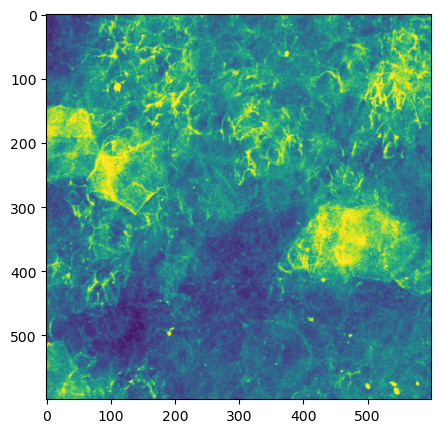

In [53]:
plt.imshow(MIP_t0_R)

In [67]:
t0_curvature

array([-1.67449531, -0.54555334,  0.0944696 , ...,  0.5581811 ,
        0.50719127,  0.5701386 ])

# Use mesh to reslice iomages

In [47]:
from measurements import reslice_by_heightmap
Z = 20

collagens = {}
collagen_mips = {}
for name,dirname in dirnames.items():
    
    f = path.join(dirname,'B_flat.tif')
    if path.exists(f) and not recalculate:
        collagens[name] = io.imread(f)
        collagen_mips[name] = collagens[name].max(axis=0)
    else:
        heightmap = heightmaps[name]
        B = io.imread(path.join(dirname,'B_reg.tif'))
        Bflat = reslice_by_heightmap(B,heightmap, 0, Z)
        io.imsave(f,Bflat)
        collagens[name] = Bflat
        collagen_mips[name] = Bflat.max(axis=0)

In [62]:
name = 'M2_R2_t0'
stackview.switch({'collagen':collagen_mips[name],'mean_curv':mean_curve[name].T},
                 colormap = ['pure_red','pure_green'],toggleable=True,zoom_factor=0.5)

In [58]:
collagen_mips[name].shape

(1024, 1024)

/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


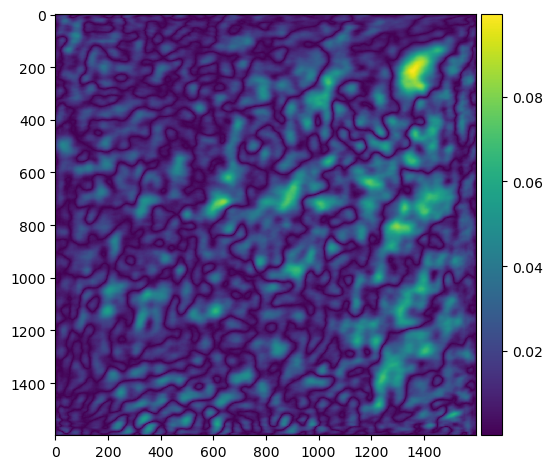

In [59]:
C = normxcorr2(collagen_mips[name][Xtrim,Ytrim],mean_curve[name][Xtrim,Ytrim])
io.imshow(C)